In [1]:
import torch
from diffusers import AutoencoderKL
from tqdm.notebook import tqdm
import numpy as np
from transformer.microdit import MicroDiT
import matplotlib.pyplot as plt
from config import VAE_CHANNELS, DIT_B as DIT, MODELS_DIR_BASE
from torch.amp import autocast
from open_clip import create_model_from_pretrained, get_tokenizer

C:\Users\swaya\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


flash_attn import failed: No module named 'flash_attn'


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path="madebyollin/sdxl-vae-fp16-fix", cache_dir=f"{MODELS_DIR_BASE}/vae").to(device)

In [5]:
input_dim = VAE_CHANNELS  # 4 channels in latent space
patch_size = (2, 2)
embed_dim = DIT["embed_dim"]
num_layers = DIT["num_layers"]
num_heads = DIT["num_heads"]
mlp_dim = embed_dim * 4
caption_embed_dim = 1152  # SigLip embeds to 1152 dims
# pos_embed_dim = 60
pos_embed_dim = None
num_experts = 8
active_experts = 2
patch_mixer_layers = 1
dropout = 0.1

In [6]:
model = MicroDiT(input_dim, patch_size, embed_dim, num_layers, 
                    num_heads, mlp_dim, caption_embed_dim,
                    num_experts, active_experts,
                    dropout, patch_mixer_layers)
model.load_state_dict(torch.load("models/microdit_model_epoch_19.pt"))

C:\Users\swaya\AppData\Local\Temp\ipykernel_19952\3425876643.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/microdit_model_epoc

<All keys matched successfully>

In [7]:
model = model.to(device).to(torch.float16)

In [8]:
SIGLIP_HF_NAME ="hf-hub:timm/ViT-SO400M-14-SigLIP-384"

In [9]:
siglip_model, _ = create_model_from_pretrained(SIGLIP_HF_NAME, precision="fp16", cache_dir=f"{MODELS_DIR_BASE}/siglip")
siglip_model = siglip_model.to(device)
siglip_tokenizer = get_tokenizer(SIGLIP_HF_NAME)

In [13]:
prompts = ["Tokyo city skyline, skyscrapers against a beautiful cloudy sky", "Closeup of a goose in a serene pond", "A european castle on a hill, surrounded by mist"]

In [14]:
texts = siglip_tokenizer(prompts, context_length=siglip_model.context_length).to(device)
caption_embeddings = siglip_model.encode_text(texts)

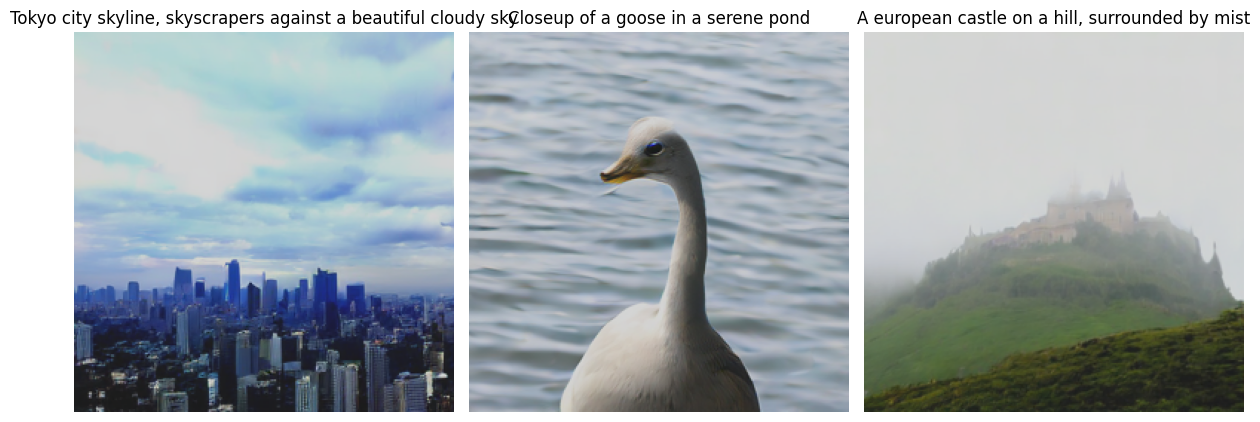

In [15]:
noise = torch.randn(3, 4, 32, 32).to(device).to(torch.float16)

with torch.inference_mode(), autocast("cuda", dtype=torch.float16):
    pred = model.sample(noise, caption_embeddings, sample_steps=100, cfg=6.0)

    pred = vae.decode(pred).sample
    # Change range of pred from x to y to -1 to 1
    min_val = pred.min()
    max_val = pred.max()

    pred = (pred - min_val) / (max_val - min_val)
    pred = 2 * pred - 1


with torch.inference_mode():
    pred_cpu = pred.cpu()
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(1, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            ax.set_title(prompts[i])  # Add this line to set the title
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()